<a href="https://colab.research.google.com/github/Jcc329/Jessica_DATA606/blob/main/Notebooks/5.2.Text_Similarity_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 606 Capstone
## Notebook 5.2
## Phase 2 Part 1: Topic Modeling
Jessica Conroy

<b> Goal: </b> 
This Notebook aims to perform topic modeling to identify key topics and differences in those topics among the pre covid and during covid time frames. 
1. LDA and NMF (non-negative matrix factorization) from game description, reviews, tags <br>
<b>2. Text similarity analysis </b>

In [1]:
!pip install gensim==3.8.0

In [2]:
!pip install googletrans==3.1.0a0

In [3]:
!pip install transformers

In [4]:
!pip install sentence_transformers

In [5]:
import torch
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertConfig, BertModel, BertTokenizer
import seaborn as sns
% matplotlib inline
np.random.seed(42);

#Import libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import textwrap

import gensim
print(gensim.__version__)
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LsiModel
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import preprocess_documents
from io import TextIOWrapper

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
# print(stopwords.words('english'))


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from googletrans import Translator

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

3.8.0
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
GameData = pd.read_csv('./FinalGameData_postProcessing.csv')

# Text Similarity Analysis

Based heavily on the work done in another text similarity project found here: https://github.com/Jcc329/Text_Summarization/blob/main/notebooks/Text_Similarity_Analysis_BERT_%26_Cos_Sim.ipynb

https://seaborn.pydata.org/generated/seaborn.heatmap.html


In [7]:
# Model choice informed by performance: https://www.sbert.net/docs/pretrained_models.html
# https://huggingface.co/sentence-transformers/all-mpnet-base-v2
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sentence_transformers import SentenceTransformer
# sbert_model = SentenceTransformer('bert-base-uncased')

from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = model.encode(sentences)
print(embeddings)

[[ 0.02250389 -0.07830366 -0.023042   ... -0.00833367  0.02655566
  -0.00199338]
 [ 0.04170033  0.0011164  -0.0155444  ... -0.02181857 -0.06357732
  -0.00875688]]


In [8]:
# GameData = pd.read_csv('./FinalGameData_postProcessing.csv')
for i in GameData['Release Year']:
    try:
        float(i)
    except:
        print(type(i))

In [9]:
#To compare across pre and during covid years, I will start by creating a matrix of siimilarities and differences based on game release year
# https://towardsdatascience.com/calculating-document-similarities-using-bert-and-other-models-b2c1a29c9630
GameData = GameData.fillna('')
GameData['detailed_description.1'] = GameData['detailed_description.1'].astype(str)
GameData['Top Reviews by Upvotes.1'] = GameData['Top Reviews by Upvotes.1'].astype(str)
GameData['tags.1'] = GameData['tags.1'].astype(str)
# Agg_on_year = GameData.groupby(['Release Year'])[['detailed_description.1', 'Top Reviews by Upvotes.1', 'tags.1']].transform(lambda x: '. '.join(x)
GameData = GameData[GameData['Release Year']!='']
GameData['Release Year'] = GameData['Release Year'].astype(float)
GameData=GameData.sort_values('Release Year')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [10]:
#Descriptions
description_embeddings = model.encode(list(GameData['detailed_description.1']))
Review_embeddings = model.encode(list(GameData['Top Reviews by Upvotes.1']))
Tag_embeddings = model.encode(list(GameData['tags.1']))

In [11]:
# len(description_embeddings)
len(GameData['detailed_description'])

14910

In [12]:
GameData['Description Embeddings'] = list(description_embeddings)
GameData['Review Embeddings'] = list(Review_embeddings)
GameData['Tag Embeddings'] = list(Tag_embeddings)

In [13]:
Agg_on_year = GameData.groupby(['Release Year'])[['Description Embeddings', 'Review Embeddings', 'Tag Embeddings']].sum()
Agg_on_year

,Description Embeddings,Review Embeddings,Tag Embeddings
Release Year,,,
1997.0,"[0.01692336, 0.050785173, -0.011044135, 0.0401...","[-0.009137378, 0.0016986484, 0.012215902, 0.03...","[-0.01921512, 0.023206487, 0.0066646775, 0.019..."
2000.0,"[-0.013020875, 0.027938621, -0.02131453, -0.01...","[0.025472082, 0.077425495, -0.017800987, 0.023...","[-0.027118292, -0.000575962, -0.021248678, 0.0..."
2004.0,"[0.010164419, 0.041291222, -0.02266597, 0.0369...","[-0.04016405, -0.025419714, -0.023259336, 0.00...","[-0.012600704, 0.014292628, -0.015551979, 0.01..."
2006.0,"[0.045644343, 0.19810581, -0.027871806, -0.216...","[-0.019898167, 0.06696039, -0.08511033, 0.0190...","[0.094150856, 0.04081236, -0.07109846, 0.01071..."
2007.0,"[-0.047193028, 0.5877098, -0.21401617, 0.11381...","[-0.105721764, 0.68651694, -0.24529238, 0.1624...","[-0.16442092, 0.25102383, -0.2142237, 0.084050..."
2008.0,"[0.19257706, 0.7799803, -0.2512589, 0.05787591...","[0.18569806, 0.66262937, -0.2980301, 0.1718090...","[0.053047173, 0.037809182, -0.16115938, -0.007..."
2009.0,"[0.83945775, 2.5821314, -0.50358695, 0.4511225...","[0.7592947, 3.1707149, -1.0070215, 0.9326678, ...","[0.43427825, 0.35613546, -0.49002123, 0.593611..."
2010.0,"[1.488039, 2.1678603, -0.7907077, 0.077985145,...","[1.149944, 3.2551558, -1.2457567, 1.159446, -0...","[0.1823079, -0.043051086, -0.65299535, 0.24295..."
2011.0,"[1.4793617, 2.2905076, -0.7581527, 0.7788382, ...","[0.37875775, 3.1951714, -1.0309161, 1.5451648,...","[0.2663421, -0.018026125, -1.2468241, 0.289835..."


In [14]:
Description_embedingsbyYR = []
for i in Agg_on_year['Description Embeddings']:
    Description_embedingsbyYR.append(np.array(i))
# Description_embedingsbyYR

In [15]:
pairwise_similarities=cosine_similarity(Description_embedingsbyYR)
pairwise_differences=euclidean_distances(Description_embedingsbyYR)

In [16]:
list(Agg_on_year.index)

[1997.0,
 2000.0,
 2004.0,
 2006.0,
 2007.0,
 2008.0,
 2009.0,
 2010.0,
 2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0,
 2017.0,
 2018.0,
 2019.0,
 2020.0,
 2021.0,
 2022.0]

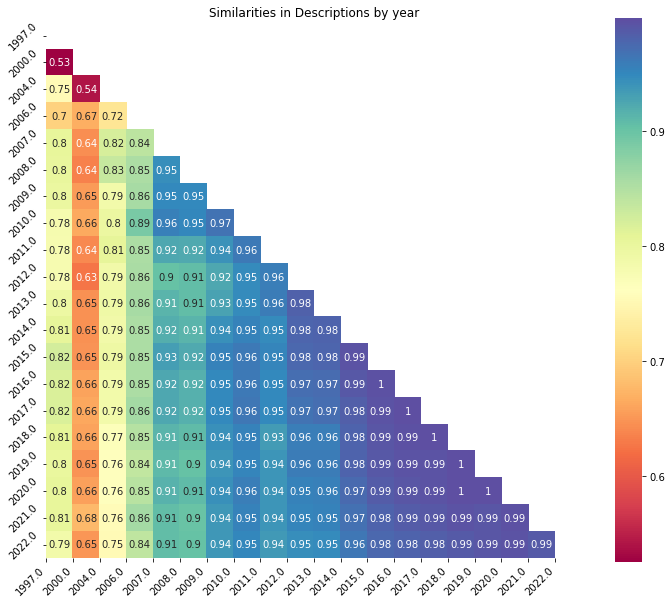

In [17]:
# Visualize similarities
fig, ax = plt.subplots(figsize=(12,10))
mask = np.zeros_like(pairwise_similarities)
mask[np.triu_indices_from(mask)] = True
pairwise_similarities
fig = sns.heatmap(pairwise_similarities,cmap="Spectral", mask=mask, annot=True, square=True).set(title='Similarities in Descriptions by year')
ax.set_xticks(range(len(Agg_on_year.index)))
ax.set_xticklabels(list(Agg_on_year.index))
ax.set_yticklabels(list(Agg_on_year.index))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=45,
    horizontalalignment='right');

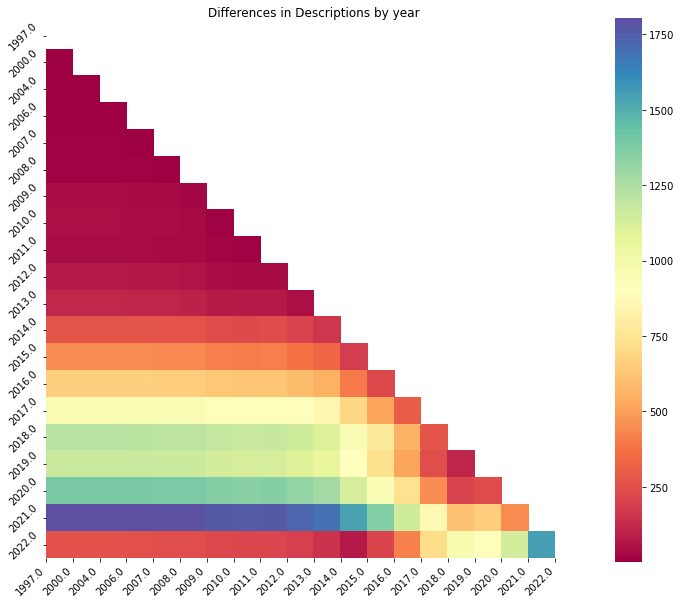

In [18]:
# Visualize Differences
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,10))
fig = sns.heatmap(
    pairwise_differences,
    cmap="Spectral", mask=mask, annot=False, square=True).set(title='Differences in Descriptions by year')
ax.set_xticks(range(len(Agg_on_year.index)))
ax.set_xticklabels(list(Agg_on_year.index))
ax.set_yticklabels(list(Agg_on_year.index))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=45,
    horizontalalignment='right');

In [19]:
Review_embedingsbyYR = []
for i in Agg_on_year['Review Embeddings']:
    Review_embedingsbyYR.append(np.array(i))

pairwise_similarities=cosine_similarity(Review_embedingsbyYR)
pairwise_differences=euclidean_distances(Review_embedingsbyYR)

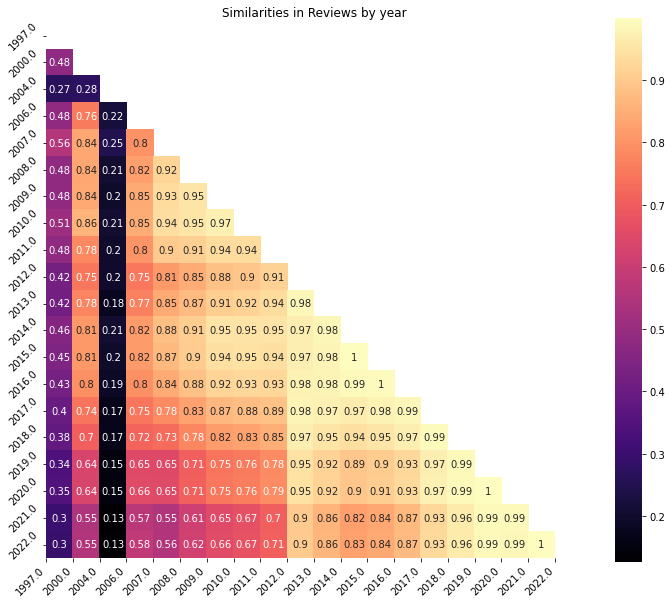

In [20]:
# Visualize similarities
fig, ax = plt.subplots(figsize=(12,10))
mask = np.zeros_like(pairwise_similarities)
mask[np.triu_indices_from(mask)] = True
pairwise_similarities
fig = sns.heatmap(pairwise_similarities,cmap="magma", mask=mask, annot=True, square=True).set(title='Similarities in Reviews by year')
ax.set_xticks(range(len(Agg_on_year.index)))
ax.set_xticklabels(list(Agg_on_year.index))
ax.set_yticklabels(list(Agg_on_year.index))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=45,
    horizontalalignment='right');

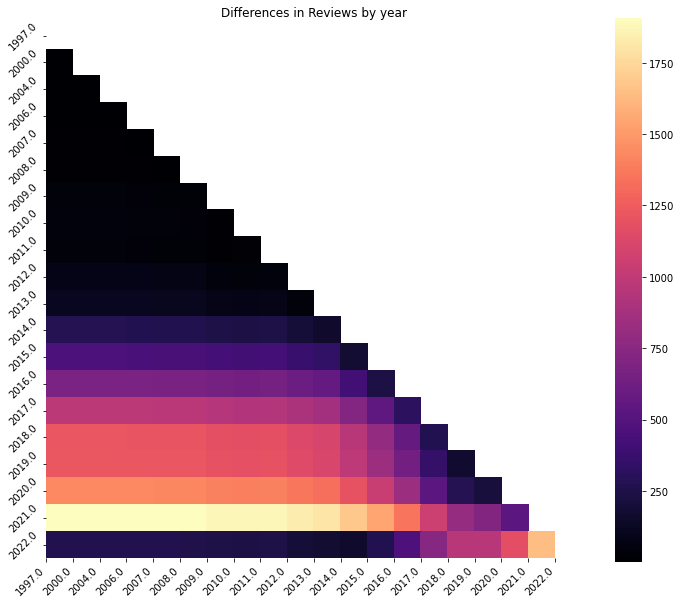

In [21]:
# Visualize Differences
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,10))
fig = sns.heatmap(
    pairwise_differences,
    cmap="magma", mask=mask, annot=False, square=True).set(title='Differences in Reviews by year')
ax.set_xticks(range(len(Agg_on_year.index)))
ax.set_xticklabels(list(Agg_on_year.index))
ax.set_yticklabels(list(Agg_on_year.index))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=45,
    horizontalalignment='right');

In [22]:
Tag_embedingsbyYR = []
for i in Agg_on_year['Review Embeddings']:
    Tag_embedingsbyYR.append(np.array(i))

pairwise_similarities=cosine_similarity(Tag_embedingsbyYR)
pairwise_differences=euclidean_distances(Tag_embedingsbyYR)

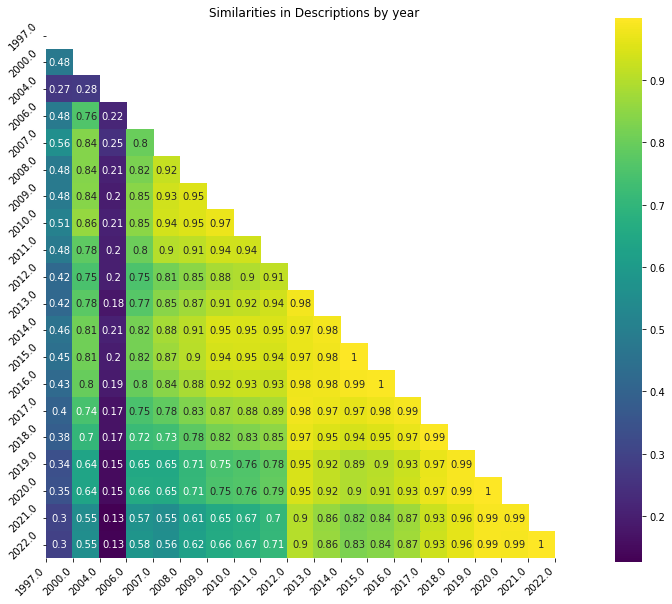

In [23]:
# Visualize similarities
fig, ax = plt.subplots(figsize=(12,10))
mask = np.zeros_like(pairwise_similarities)
mask[np.triu_indices_from(mask)] = True
pairwise_similarities
fig = sns.heatmap(pairwise_similarities,cmap="viridis", mask=mask, annot=True, square=True).set(title='Similarities in Descriptions by year')
ax.set_xticks(range(len(Agg_on_year.index)))
ax.set_xticklabels(list(Agg_on_year.index))
ax.set_yticklabels(list(Agg_on_year.index))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=45,
    horizontalalignment='right');

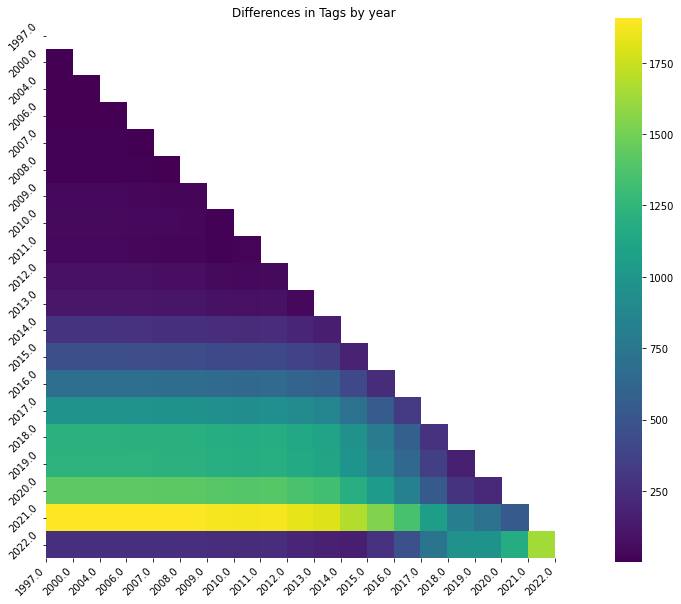

In [24]:
# Visualize Differences
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,10))
fig = sns.heatmap(
    pairwise_differences,
    cmap="viridis", mask=mask, annot=False, square=True).set(title='Differences in Tags by year')
ax.set_xticks(range(len(Agg_on_year.index)))
ax.set_xticklabels(list(Agg_on_year.index))
ax.set_yticklabels(list(Agg_on_year.index))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=45,
    horizontalalignment='right');

# Compare pre-covid and during covid directly

In [25]:
preCOVID = GameData[GameData['Release Year'].isin([2018,2019])]
COVID = GameData[GameData['Release Year'].isin([2021,2022])]

Covid_Status = []
for year in GameData['Release Year']:
    if year in [2018,2019]:
        Covid_Status.append('precovid')
    elif year in [2021,2022]:
        Covid_Status.append('covid')
    else:
        Covid_Status.append('none')
GameData['Covid Status'] = Covid_Status

In [26]:
Agg_on_status = GameData.groupby(['Covid Status'])[['Description Embeddings', 'Review Embeddings', 'Tag Embeddings']].sum()
# Agg_on_year

In [27]:
Description_embedingsbyYR = []
for i in Agg_on_status['Description Embeddings']:
    Description_embedingsbyYR.append(np.array(i))

Review_embedingsbyYR = []
for i in Agg_on_status['Review Embeddings']:
    Review_embedingsbyYR.append(np.array(i))

Tag_embedingsbyYR = []
for i in Agg_on_status['Tag Embeddings']:
    Tag_embedingsbyYR.append(np.array(i))


In [28]:
pairwise_similarities=cosine_similarity(Description_embedingsbyYR)
pairwise_differences=euclidean_distances(Description_embedingsbyYR)

print('Cosine Similarity: ' + str(pairwise_similarities[0][1]))
print('Euclidean Distance: ' + str(pairwise_differences[0][1]))

Cosine Similarity: 0.9916935
Euclidean Distance: 2055.0164


In [29]:
pairwise_similarities

array([[1.       , 0.9916935, 0.9938202],
       [0.9916935, 1.0000001, 0.9971822],
       [0.9938202, 0.9971822, 1.0000001]], dtype=float32)

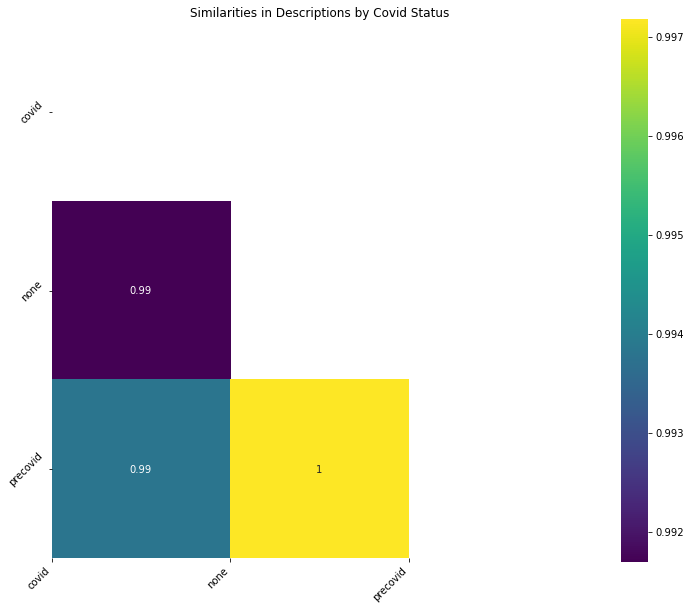

In [30]:
# Visualize similarities
fig, ax = plt.subplots(figsize=(12,10))
mask = np.zeros_like(pairwise_similarities)
mask[np.triu_indices_from(mask)] = True
pairwise_similarities
fig = sns.heatmap(pairwise_similarities,cmap="viridis", mask=mask, annot=True, square=True).set(title='Similarities in Descriptions by Covid Status')
ax.set_xticks(range(len(Agg_on_status.index)))
ax.set_xticklabels(list(Agg_on_status.index))
ax.set_yticklabels(list(Agg_on_status.index))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=45,
    horizontalalignment='right');

In [31]:
pairwise_similarities=cosine_similarity(Review_embedingsbyYR)
pairwise_differences=euclidean_distances(Review_embedingsbyYR)

print('Cosine Similarity: ' + str(pairwise_similarities[0][1]))
print('Euclidean Distance: ' + str(pairwise_differences[0][1]))

Cosine Similarity: 0.931086
Euclidean Distance: 2223.7173


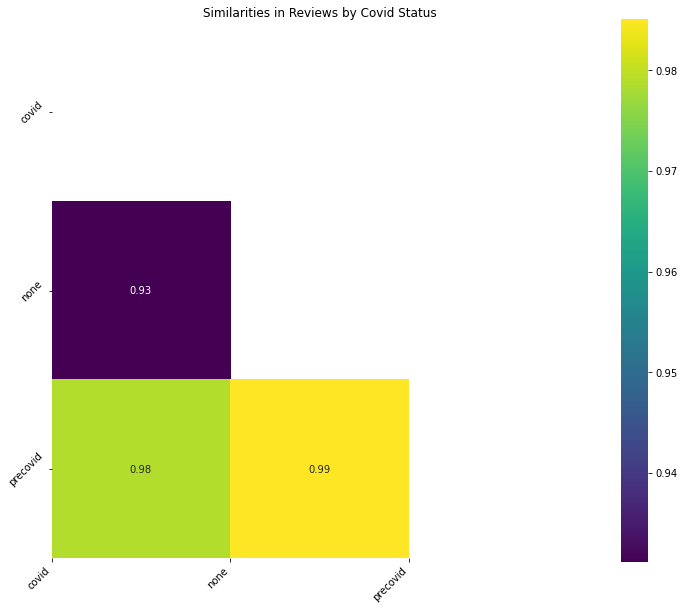

In [32]:
# Visualize similarities
fig, ax = plt.subplots(figsize=(12,10))
mask = np.zeros_like(pairwise_similarities)
mask[np.triu_indices_from(mask)] = True
pairwise_similarities
fig = sns.heatmap(pairwise_similarities,cmap="viridis", mask=mask, annot=True, square=True).set(title='Similarities in Reviews by Covid Status')
ax.set_xticks(range(len(Agg_on_status.index)))
ax.set_xticklabels(list(Agg_on_status.index))
ax.set_yticklabels(list(Agg_on_status.index))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=45,
    horizontalalignment='right');

In [33]:
pairwise_similarities=cosine_similarity(Tag_embedingsbyYR)
pairwise_differences=euclidean_distances(Tag_embedingsbyYR)

print('Cosine Similarity: ' + str(pairwise_similarities[0][1]))
print('Euclidean Distance: ' + str(pairwise_differences[0][1]))

Cosine Similarity: 0.8845105
Euclidean Distance: 2254.3296


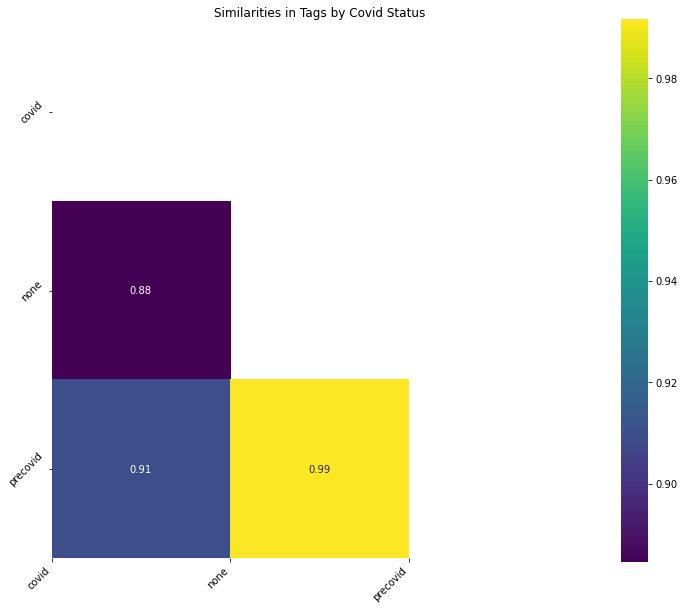

In [34]:
# Visualize similarities
fig, ax = plt.subplots(figsize=(12,10))
mask = np.zeros_like(pairwise_similarities)
mask[np.triu_indices_from(mask)] = True
pairwise_similarities
fig = sns.heatmap(pairwise_similarities,cmap="viridis", mask=mask, annot=True, square=True).set(title='Similarities in Tags by Covid Status')
ax.set_xticks(range(len(Agg_on_status.index)))
ax.set_xticklabels(list(Agg_on_status.index))
ax.set_yticklabels(list(Agg_on_status.index))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=45,
    horizontalalignment='right');